In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import os
import datetime
from sklearn.model_selection import train_test_split

In [5]:
data = pd.read_pickle('DR_Data/pickup_series_12h.pickle')
pickups = np.array(data.Hubs)

num_zones = pickups[0].shape[0]
seq_length = 2
num_intervals = pickups.shape[0]-2
validation_size = 0.1

X = np.zeros((num_zones, seq_length, num_intervals))
y = np.zeros((num_zones, 1, num_intervals))
for i in range(num_intervals):
    X[:,:,i] = np.array([pickups[i], pickups[i+1]]).T
    y[:,:,i] = np.array([pickups[i+2]]).T
    
print(X.shape,y.shape)
X_train, X_valid, y_train, y_valid = train_test_split(X.T, y.T, test_size=validation_size, random_state=1)
print(X_train.shape, y_train.shape)

(100, 2, 788) (100, 1, 788)
(709, 2, 100) (709, 1, 100)


In [1]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, Dropout2d, MaxPool2d, BatchNorm1d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [2]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


In [ ]:
inputs = get_variable(torch.Tensor(X_valid[0]))


In [5]:
rnn_seq_length = seq_length
rnn_input_size = num_zones
rnn_hidden_size = 16
rnn_direction = 0
rnn_layers = 2

rnn_out_features = rnn_seq_length*rnn_hidden_size*(rnn_direction+1)
features_cat_size = rnn_out_features

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()        
        self.drop = Dropout(p=0.5)
        self.bn0 = BatchNorm1d(rnn_seq_length)
        
        self.rnn_1 = nn.LSTM(input_size=rnn_input_size,
                            hidden_size=rnn_hidden_size,
                            num_layers=rnn_layers,
                            bidirectional=(rnn_direction>0),
                            dropout=0.5)
        
        self.l_out = Linear(in_features=features_cat_size,
                            out_features=num_zones,
                            bias=False)
        
    def forward(self, x):
        features = []
        out = {}
        #x = self.bn0(x)
        
        features_rnn = x.view(rnn_seq_length, -1, rnn_input_size)
        features_rnn,_ = self.rnn_1(features_rnn)
        # features_rnn = self.drop(features_rnn)
        
        features_rnn = features_rnn.view(-1, rnn_out_features) #self.rnn_1.hidden_size)
        
        # Append features to the list "features"
        features.append(features_rnn)
        
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)
        
        #features_final = self.drop(features_final)
        out['out'] = self.l_out(features_final)
        return out['out']

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (bn0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn_1): LSTM(100, 16, num_layers=2, dropout=0.5)
  (l_out): Linear(in_features=32, out_features=100, bias=False)
)


Epoch 0 	 train loss: 2.5096293365 	 valid loss: 2.5113006078
Epoch 5 	 train loss: 1.8836227031 	 valid loss: 1.8770124861
Epoch 10 	 train loss: 1.7508433704 	 valid loss: 1.7660012087
Epoch 15 	 train loss: 1.5871240199 	 valid loss: 1.6712986687
Epoch 20 	 train loss: 1.5270672473 	 valid loss: 1.6682321905
Epoch 25 	 train loss: 1.4741789439 	 valid loss: 1.6452297302
Epoch 30 	 train loss: 1.4369547816 	 valid loss: 1.6592616488
Epoch 35 	 train loss: 1.4100924695 	 valid loss: 1.6251161433
Epoch 40 	 train loss: 1.3604766694 	 valid loss: 1.6356543970
Epoch 45 	 train loss: 1.3462419833 	 valid loss: 1.6513800811
Epoch 50 	 train loss: 1.3162967301 	 valid loss: 1.5885428575
Epoch 55 	 train loss: 1.3108068341 	 valid loss: 1.5535442527
Epoch 60 	 train loss: 1.2904903266 	 valid loss: 1.5934825251
Epoch 65 	 train loss: 1.3066787093 	 valid loss: 1.5572038544
Epoch 70 	 train loss: 1.2852715769 	 valid loss: 1.5473545217
Epoch 75 	 train loss: 1.2663862802 	 valid loss: 1.54736

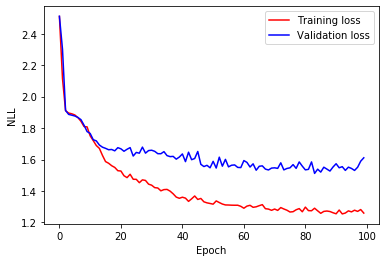

In [6]:
# Hyper-parameters
num_epochs = 100

# Initialize a new network
net = Net()

# Define a loss function and optimizer
criterion = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.SGD(net.parameters(), lr=0.01,momentum=0.2, weight_decay=1e-3)

def accuracy(ys, ts):
    predictions = torch.round(ys)
    correct_prediction = torch.eq(torch.round(outputs),targets)
    return torch.mean(correct_prediction.float())

# Track loss
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_training_accs = 0
    epoch_validation_loss = 0
    epoch_validation_accs = 0
    
    net.eval()
    for j in range(len(X_valid)):
        inputs = torch.Tensor(X_valid[j])
        targets = torch.Tensor(y_valid[j])
        # Forward pass
        outputs = net.forward(inputs)
        # Compute loss
        loss = criterion(outputs,targets)
        # Update loss
        epoch_validation_loss += loss.detach().numpy()
        epoch_validation_accs += accuracy(outputs, targets)
    
    net.train()
    for j in range(len(X_train)):
        inputs = torch.Tensor(X_train[j])
        targets = torch.Tensor(y_train[j])
        outputs = net.forward(inputs)
        # Compute loss
        loss = criterion(outputs,targets)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update loss
        epoch_training_loss += loss.detach().numpy()
        epoch_training_accs += accuracy(outputs, targets)
        
    # Save loss for plot
    train_loss.append(epoch_training_loss/len(X_train))
    train_accs.append(epoch_training_accs/len(X_train))
    valid_loss.append(epoch_validation_loss/len(X_valid))
    valid_accs.append(epoch_training_accs/len(X_valid))

    # Print loss every 5 epochs
    if i % 5 == 0:
        print(f'Epoch {i} \t train loss: {train_loss[-1]:.10f} \t valid loss: {valid_loss[-1]:.10f}')


# Plot training and validation loss
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss, 'r', label='Training loss',)
plt.plot(epoch, valid_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

In [10]:
print(outputs.shape, targets.shape)
print(X_train.shape)

torch.Size([1, 100]) torch.Size([1, 100])
(1419, 2, 100)
